In [1]:
using LinearAlgebra
using Random
using Distributions
using KernelDensity
include("../Inversion/Plot.jl")
include("../Inversion/GaussianMixture.jl")
include("../Inversion/GMBBVI.jl")
include("../Inversion/AnnealingInitialize.jl")
include("./MultiModal.jl")
Random.seed!(123);


In [2]:
function visualization(ax, objs, func_Phi;
    label = nothing, Nx = 200, Ny = 200, x_lim = [-3.0, 3.0], y_lim = [-3.0, 3.0], N_iter = 200)
    
    x_min, x_max = x_lim 
    y_min, y_max = y_lim

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'
    Z_ref = posterior_2d(func_Phi, X, Y, "func_Phi")
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    N_param = length(objs)
    N_trials = length(objs[1])
    errors = zeros(N_trials, N_iter+1, N_param)

    for (i_param, obj) in enumerate(objs)
        for (i, bbvi_obj) in enumerate(obj)
            for iter = 0:N_iter
                x_w = exp.(bbvi_obj.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = bbvi_obj.x_mean[iter+1][:,1:2]
                xx_cov = bbvi_obj.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
                errors[i, iter+1, i_param] = norm(Z - Z_ref,1)*dx*dy
                if i == 1 && iter == N_iter  
                    # plot the outcome of the first trial 
                    ax[i_param + 1].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                    ax[i_param + 1].scatter([bbvi_obj.x_mean[1][:,1];], [bbvi_obj.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                    ax[i_param + 1].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                    ax[i_param + 1].set_xlim(x_lim)
                    ax[i_param + 1].set_ylim(y_lim)
                end
            end
        end
    end

    error_mean = reshape(mean(errors, dims=1), N_iter+1, N_param)
    error_std = reshape(std(errors, dims=1), N_iter+1, N_param)


    for i = 1:N_param

        if label === nothing
            ax[end].semilogy(Array(0:N_iter), error_mean[:,i])
        else
            ax[end].semilogy(Array(0:N_iter), error_mean[:,i], label = label[i])
        end
    
        # ax[end].fill_between(Array(0:N_iter), error_mean[:,i] - error_std[:,i], error_mean[:,i] + error_std[:,i], color="blue", alpha=0.25)

    end

    ax[end].legend()
end




visualization (generic function with 1 method)

## Sensitivity Test
We test the sensitivity of GMBBVI on initial conditions, number of modes and scheduler using a 10-modes Gaussian mixture functions.
- Initial conditions:
- Number of modes(J): J=20 or J=40
- scheduler: cos_annealling, stable_cos_decay, stable_linear_decay

[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)
[ Info: ("iter = ", 500, " / ", 500)
[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)
[ Info: ("iter = ", 500, " / ", 500)
[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ In

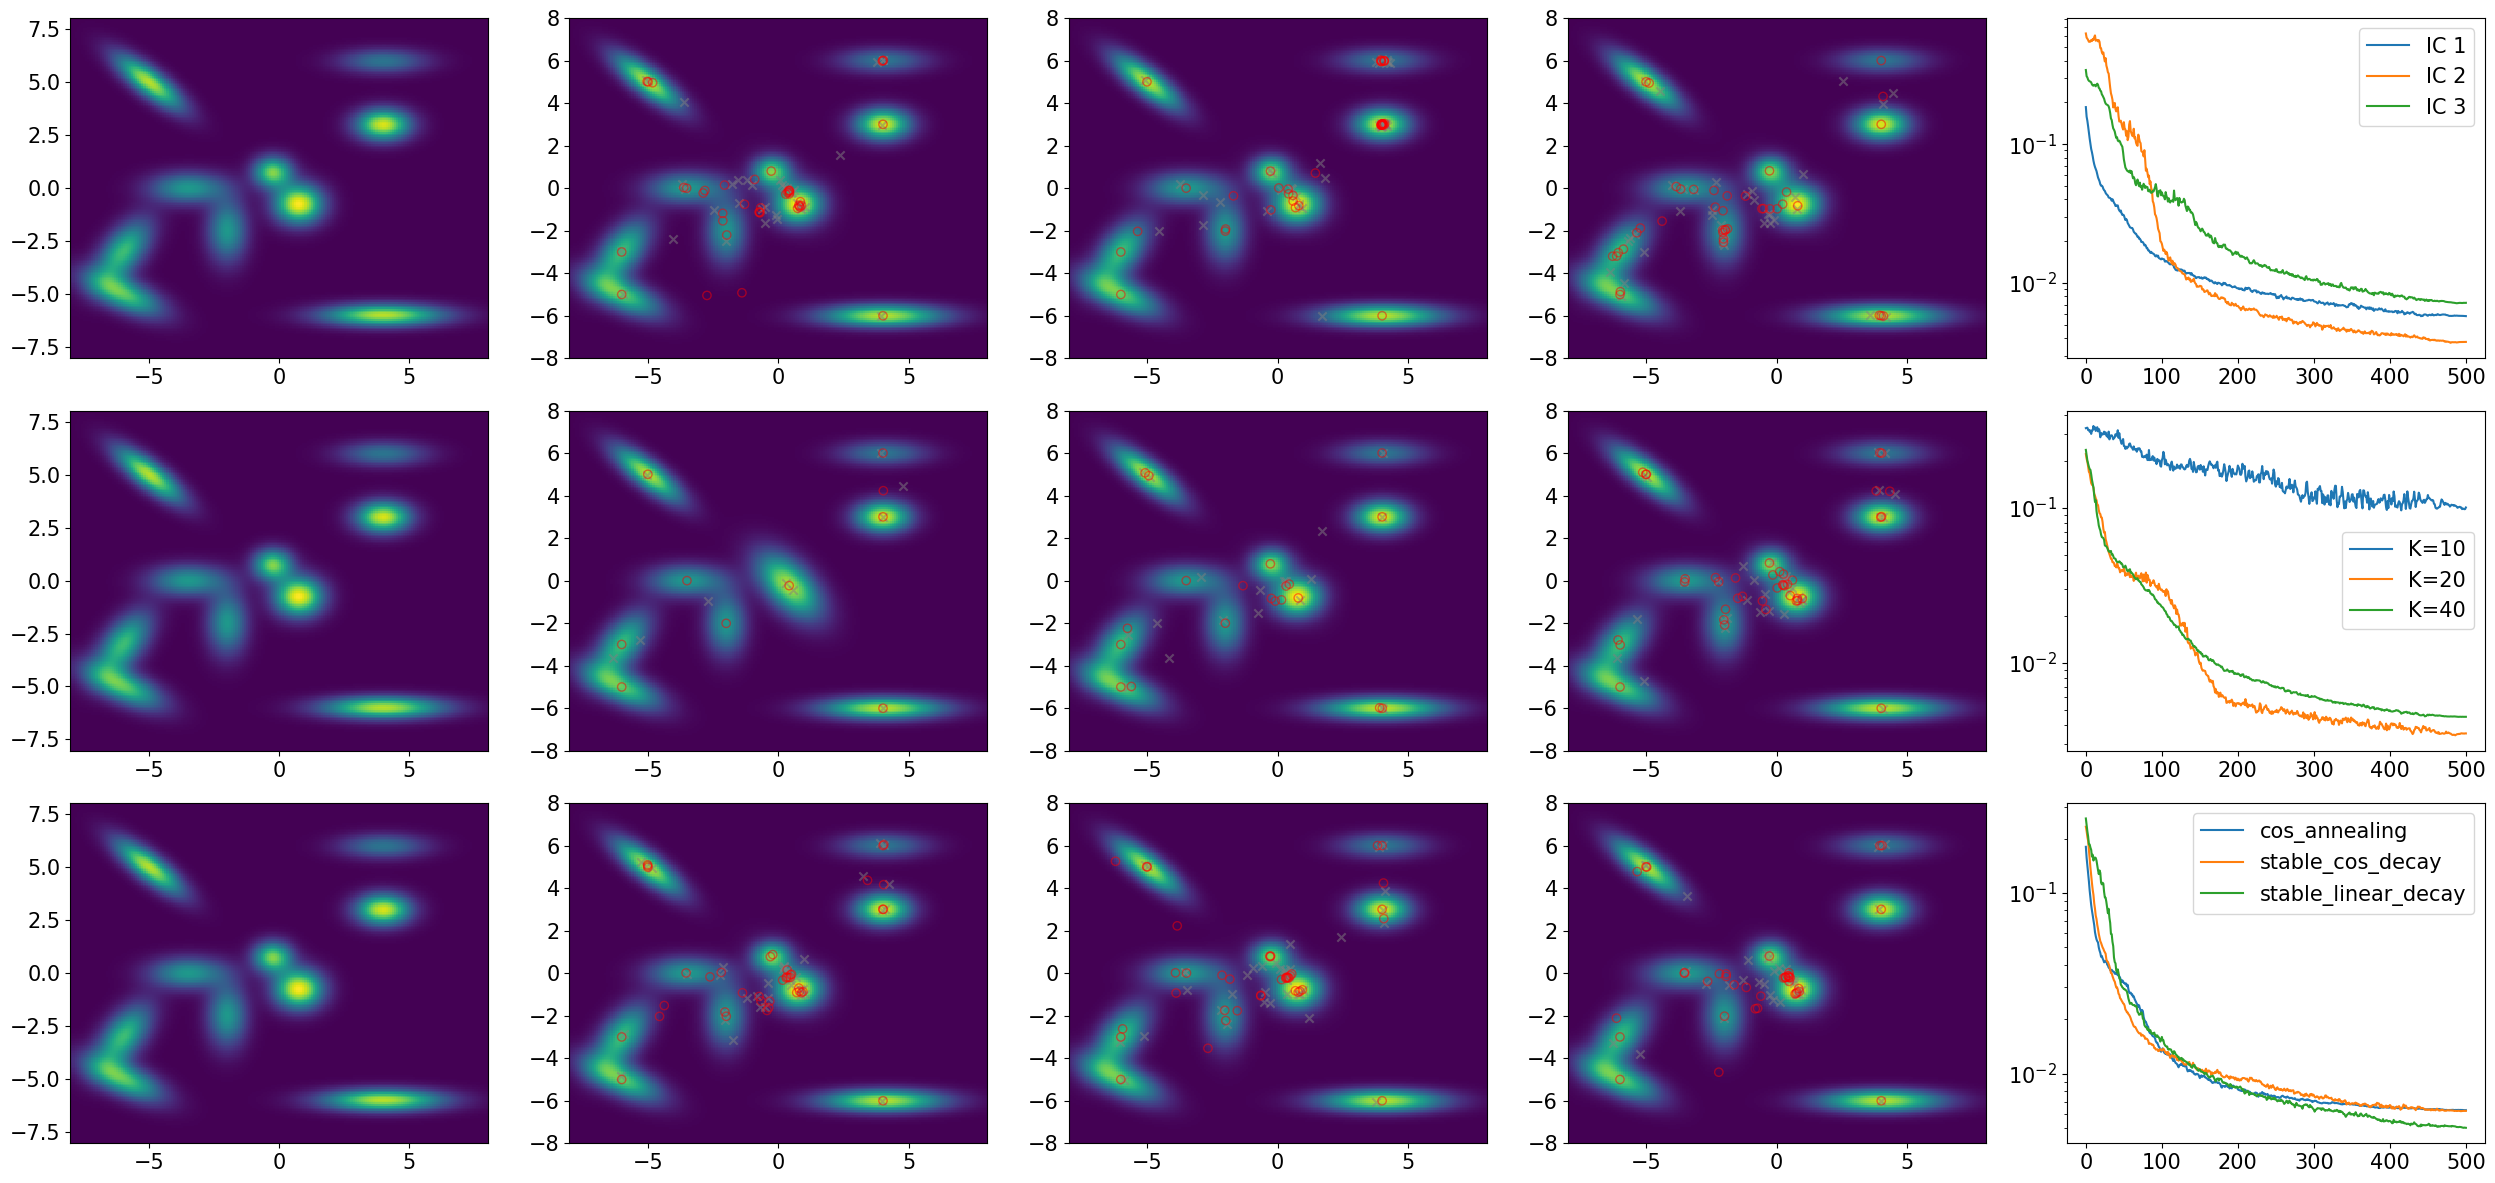

In [3]:
N_modes_array = [10, 20, 40]
N_modes = maximum(N_modes_array)
N_x, N_ens = 2, 5

fig, ax = PyPlot.subplots(nrows=3, ncols=5, sharex=false, sharey=false, figsize=(25,12))

x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = zeros(2), [1.0  0.0; 0.0  1.0]
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end


N_iter = 500
N_trials = 3 
dt = 0.5


Gtype = "Gaussian_mixture"
gm_args = Gaussian_mixture_args(N_x = N_x)
gm_args_marginal = Gaussian_mixture_args(N_x = 2)

func_Phi(x) = -log_Gaussian_mixture(x, gm_args)


### Test on initial condition

x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)
objs = []
obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens)  for _ = 1:N_trials]
push!(objs, obj)

x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean + 2*ones(N_modes, N_x), xx0_cov)
obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens)  for _ = 1:N_trials]
push!(objs, obj)

x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean - 2*ones(N_modes, N_x), xx0_cov)
obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens)  for _ = 1:N_trials]
push!(objs, obj)

label = ["IC 1", "IC 2", "IC 3"]
visualization(ax[1,:], objs, func_Phi; label= label, x_lim = [-8.0, 8.0], y_lim = [-8.0, 8.0], N_iter = N_iter)


## Test on modes number

objs = []
for n in N_modes_array
    x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w[1:n], x0_mean[1:n,:], xx0_cov[1:n,:,:])

    obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens)  for _ = 1:N_trials]

    push!(objs, obj)
end
label = ["K=10", "K=20", "K=40"]
visualization(ax[2,:], objs, func_Phi; label = label, x_lim = [-8.0, 8.0], y_lim = [-8.0, 8.0], N_iter = N_iter)


### Test on scheduler

scheduler_array = ["cos_annealing", "stable_cos_decay", "stable_linear_decay"]
objs = []
for scheduler_type in scheduler_array
    x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov)

    obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens, scheduler_type = scheduler_type)  for _ = 1:N_trials]

    push!(objs, obj)
end
visualization(ax[3,:], objs, func_Phi; label = scheduler_array, x_lim = [-8.0, 8.0], y_lim = [-8.0, 8.0], N_iter = N_iter)


fig.tight_layout()
fig.savefig("GMBBVI-params.pdf")